# Xception Model

# Part-1 Importing Libraries

In [1]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D,Input,Dropout,LeakyReLU,Activation
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Part-2 Data Preprocessing

In [2]:
img_height, img_width = (64,64)
batch_size = 32

train_data_dir = r"dataset/training_set"
valid_data_dir = r"dataset/validation_set"
test_data_dir = r"dataset/test_set"

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical')

valid_generator = train_datagen.flow_from_directory(
            valid_data_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical')

Found 2723 images belonging to 2 classes.
Found 290 images belonging to 2 classes.


In [4]:
test_generator = train_datagen.flow_from_directory(
            test_data_dir,
            target_size=(img_height, img_width),
            batch_size=1,
            class_mode='categorical')

Found 1060 images belonging to 2 classes.


In [5]:
x,y = test_generator.next()
x.shape

(1, 64, 64, 3)

# Part-3 Xception Model - Building and Training

In [6]:
base_model = Xception(include_top=False,weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(train_generator,validation_data = valid_generator, epochs=25)

Epoch 1/25
86/86 [==============================] - 26s 300ms/step - loss: 0.2687 - accuracy: 0.9012 - val_loss: 0.0717 - val_accuracy: 0.9862
Epoch 2/25
86/86 [==============================] - 26s 298ms/step - loss: 0.1361 - accuracy: 0.9537 - val_loss: 0.1023 - val_accuracy: 0.9586
Epoch 3/25
86/86 [==============================] - 26s 298ms/step - loss: 0.1371 - accuracy: 0.9552 - val_loss: 0.0733 - val_accuracy: 0.9759
Epoch 4/25
86/86 [==============================] - 26s 301ms/step - loss: 0.1086 - accuracy: 0.9629 - val_loss: 0.0808 - val_accuracy: 0.9828
Epoch 5/25
86/86 [==============================] - 27s 310ms/step - loss: 0.1205 - accuracy: 0.9570 - val_loss: 0.1010 - val_accuracy: 0.9759
Epoch 6/25
86/86 [==============================] - 26s 301ms/step - loss: 0.1269 - accuracy: 0.9552 - val_loss: 0.1222 - val_accuracy: 0.9724
Epoch 7/25
86/86 [==============================] - 26s 302ms/step - loss: 0.0750 - accuracy: 0.9750 - val_loss: 0.0792 - val_accuracy: 0.9793

In [7]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [8]:
model.save('xcep.h5')

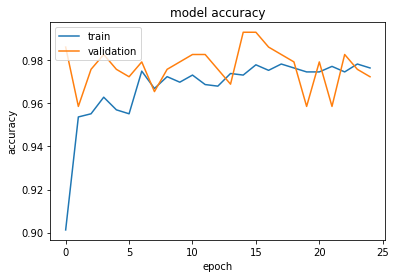

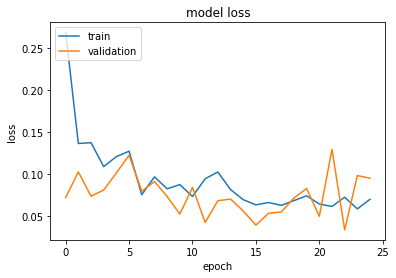

In [9]:
import matplotlib.pyplot as plt
(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Part-4 Evaluation Metrics

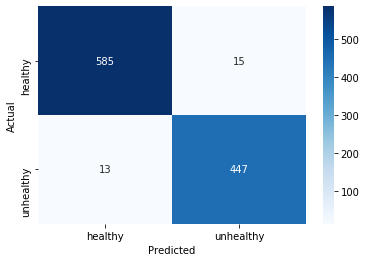

test_accuracy: 97.35849056603773


In [10]:
import pandas as pd
import seaborn as sn
import tensorflow as tf
from sklearn.metrics import confusion_matrix

model = tf.keras.models.load_model("xcep.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df =pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Blues', annot=True,fmt='d')
plt.show()
print('test_accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
accuracy = accuracy_score(predicted_class, actual_class)
print("ACCURACY: " + str(accuracy))
precision = precision_score(predicted_class, actual_class, pos_label = "healthy")
print("PRECISION: " + str(precision))
recall = recall_score(predicted_class, actual_class, pos_label = "healthy")
print("RECALL: "+ str(recall))
f1 = f1_score(predicted_class, actual_class, pos_label = "healthy")
print("F1: " + str(f1))
matrix = confusion_matrix(actual_class, predicted_class)
print("CONFUSION MATRIX: ")
print(matrix)

ACCURACY: 0.9735849056603774
PRECISION: 0.975
RECALL: 0.9782608695652174
F1: 0.9766277128547579
CONFUSION MATRIX: 
[[585  15]
 [ 13 447]]
